In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from combat.pycombat import pycombat
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import itertools
from diptest import diptest
import seaborn as sns
import joblib
from joblib import parallel_backend
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from scipy.stats import wilcoxon
import warnings

In [2]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\Script\\DatasetFull'

In [3]:
os.chdir("../../SYMBOL/Dataset")

Applico Combat

In [41]:
dataset = pd.read_csv('MergedDatasetFull_symbol.csv')
np.random.seed(42)
dataset = dataset[np.random.permutation(dataset.columns)]
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
sampleID = dataset['SampleID']
label = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

# # ## Batch removal
dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', label)

dataset

Found 8 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


SampleID  Label     TRAK2   MARCHF5  \
0                0-GSM1026056_600009.0001      1  9.597071  6.172613   
1     0-GSM1026057_600009.0001-FollowUp_1      1  9.039251  6.532620   
2                 0-GSM1026058_41461.0001      1  8.791386  6.548371   
3                 0-GSM1026059_41462.0001      1  9.373170  7.116801   
4                0-GSM1026060_600029.0001      1  9.076237  7.104757   
...                                   ...    ...       ...       ...   
1033                      7-GSM545842_M10      1  8.955028  6.642111   
1034                      7-GSM545843_M11      1  9.101329  6.715089   
1035           7-GSM545844_M11-FollowUp_1      1  9.271382  6.670915   
1036                      7-GSM545845_M12      1  9.351712  6.679360   
1037           7-GSM545846_M12-FollowUp_1      1  9.292476  6.678637   

          AVIL    CLSTN1    TAPBPL     TRIM38     GDF11    TBXA2R  ...  \
0     6.183003  7.619254  8.451946   9.674435  6.629841  6.700156  ...   
1     6.350718  7.841904  8.629886   9.565077  6.824635  6.727150  ...   
2     6.933703  7.279164  8.166420   9.772884  6.515736  6.363606  ...   
3     7.012218  7.233344  8.338171   9.725869  6.458866  6.108414  ...   
4     6.515409  7.488312  8.355218  10.033820  6.189225  6.473050  ...   
...        ...       ...       ...        ...       ...       ...  ...   
1033  6.639887  7.445428  8.359939   9.682368  6.735513  6.554890  ...   
1034  6.611748  7.449074  8.112262   9.634445  6.503292  6.350074  ...   
1035  6.620238  7.404586  8.119619   9.650254  6.681918  6.342317  ...   
1036  6.581669  7.442222  8.282929   9.638524  6.409742  6.433034  ...   
1037  6.662260  7.397570  8.343229   9.653412  6.024943  6.410587  ...   

            TKT   PAK1IP1     NDUFA1      PEX7      NET1     TMED5      FADD  \
0     11.264573  7.339375  10.188925  6.535162  7.816546  9.744325  8.263995   
1     11.293242  7.251840  10.255465  6.432247  7.916046  9.687447  8.241698   
2     11.377160  7.279236  10.101372  6.495679  8.104559  9.632676  8.242744   
3     11.373784  7.311252  10.314306  6.353293  7.386301  9.769748  8.376067   
4     11.263786  7.289160  10.243407  6.334131  7.331289  9.626407  8.217957   
...         ...       ...        ...       ...       ...       ...       ...   
1033  11.589049  7.015461  10.312671  5.698647  7.380776  9.698418  8.155223   
1034  11.215584  7.259678  10.357670  6.671623  7.428976  9.763741  8.122246   
1035  11.213354  7.351145  10.208762  6.715863  7.705067  9.785031  8.103883   
1036  11.254584  7.178289  10.401224  6.861365  7.413546  9.703183  8.135620   
1037  11.255919  7.309705  10.255236  6.813299  7.595989  9.750070  8.454906   

         URGCP      MDM4    BMPR1A  
0     7.352167  8.662674  6.263145  
1     7.349809  8.445578  7.242537  
2     7.205897  8.071700  6.124447  
3     7.312015  8.425182  6.534315  
4     7.254979  7.917974  6.195773  
...        ...       ...       ...  
1033  7.361099  8.327890  6.361955  
1034  7.262578  8.175908  7.282642  
1035  7.362873  8.131763  7.425195  
1036  7.244212  8.187447  6.908857  
1037  7.257439  8.178654  6.913615  

[1038 rows x 6675 columns]

Numero di MS: 676
Numero di Control: 362


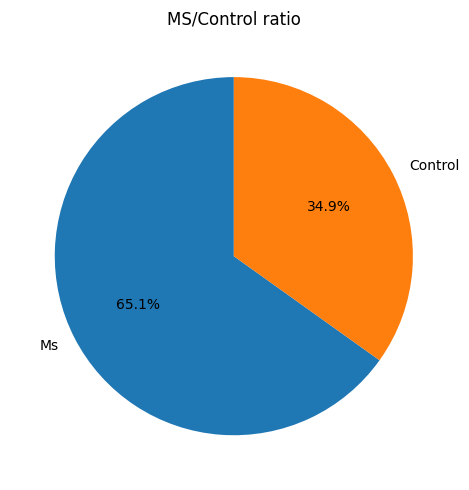

In [42]:
Ms = dataset[dataset['Label'] == 1].shape[0]
Control = dataset[dataset['Label'] == 0].shape[0]

print("Numero di MS:", Ms)
print("Numero di Control:", Control)

plt.figure(figsize=(5, 5))

plt.pie([Ms, Control], labels=['Ms', 'Control'], autopct='%1.1f%%', startangle=90)
plt.title('MS/Control ratio')

plt.tight_layout()
plt.show()

<h2>Inferenza genere</h2>

Genere noto

In [6]:
dataset['mergeID'] = dataset['SampleID'].apply(lambda x: x.split('_')[0].split('-')[1])

def genderMapping(fileMapPath):
    mapping = pd.read_csv(f"{fileMapPath}", sep="\t", header=None)
    mapping.drop([0], axis=1, inplace=True)
    mapping = mapping.T
    mapping.columns = ["GSM", "Gender"]
    mapping['Gender'] = mapping['Gender'].apply(lambda x: x.split(" ")[1])
    return mapping

gse41848Mapping = genderMapping("../../../Dataset/DatasetInfo/GSE41848.txt")
gse41849Mapping = genderMapping("../../../Dataset/DatasetInfo/GSE41849.txt")
gse146383Mapping = genderMapping("../../../Dataset/DatasetInfo/GSE146383.txt")
gse41890Mapping = genderMapping("../../../Dataset/DatasetInfo/GSE41890.txt")

mapping = pd.concat([gse41848Mapping, gse41849Mapping, gse146383Mapping], axis=0)

dataset = pd.merge(dataset, mapping, left_on='mergeID', right_on='GSM', how='left')
dataset.drop(['mergeID', 'GSM'], axis=1, inplace=True)

datasetGenderExact = dataset[dataset['Gender'].isna() == False]

In [7]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\SYMBOL\\Dataset'

Inferenza di genere con Kmeans e plot PCA

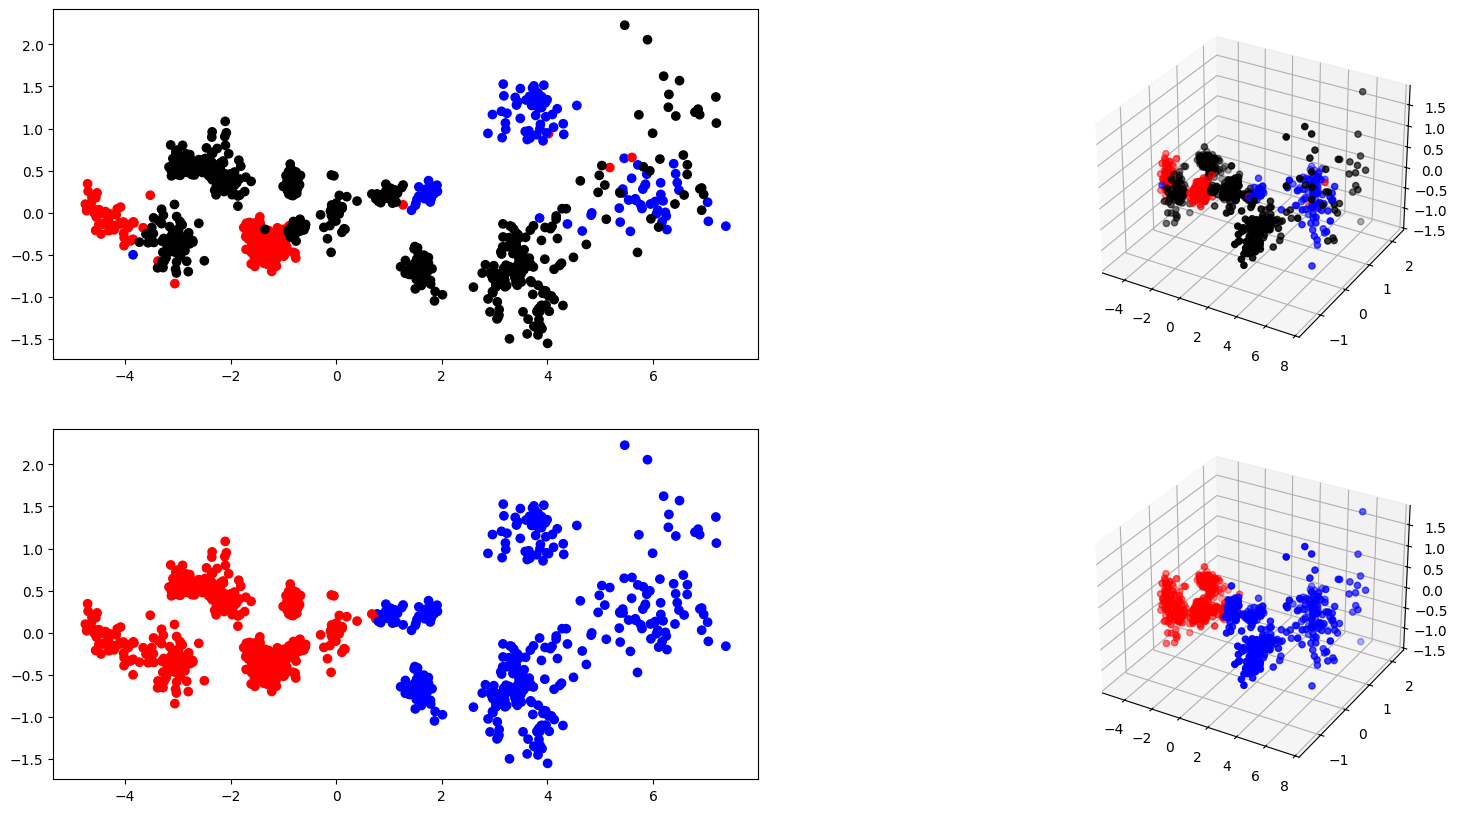

In [8]:
y_linked_genes = pd.read_csv("../../../Dataset/Y_linked_genes.txt", sep=',')

current = dataset.copy()
common_y_genes = list(y_linked_genes[y_linked_genes['HGNC symbol'].isin(current.columns)]['HGNC symbol'])

colors = []

for gender in current['Gender']:
    if gender == 'Male' or gender=='male':
        colors.append('blue')
    elif gender == 'Female' or gender == 'female':
        colors.append('red')
    else:
        colors.append('black')

pca = PCA(n_components=2).fit_transform(current[common_y_genes])
pca3 = PCA(n_components=3).fit_transform(current[common_y_genes])

fig = plt.figure(figsize=(20, 10))

plot1 = fig.add_subplot(221)
plot2 = fig.add_subplot(222, projection='3d')
plot3 = fig.add_subplot(223)
plot4 = fig.add_subplot(224, projection='3d')

plot1.scatter(pca[:, 0], pca[:, 1], c=colors)
plot2.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=colors)

kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels = kmeans.fit_predict(current[common_y_genes])

# Assegna il genere in base all'espressione media dei geni Y
male_cluster = np.argmax([current[common_y_genes][labels == i].mean().mean() for i in range(2)])
current['Gender'] = ['Male' if l == male_cluster else 'Female' for l in labels]

colors = []

for gender in current['Gender']:
    if gender == 'Male':
        colors.append('blue')
    elif gender == 'Female':
        colors.append('red')
    else:
        colors.append('black')

pca = PCA(n_components=2).fit_transform(current[common_y_genes])
pca3 = PCA(n_components=3).fit_transform(current[common_y_genes])

plot3.scatter(pca[:, 0], pca[:, 1], c=colors)
plot4.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=colors)

Numero totale di maschi: 373
Numero totale di femmine: 665
Numero di maschi Ms: 237
Numero di femmine Ms: 439
Numero di maschi Control: 136
Numero di femmine Control: 226


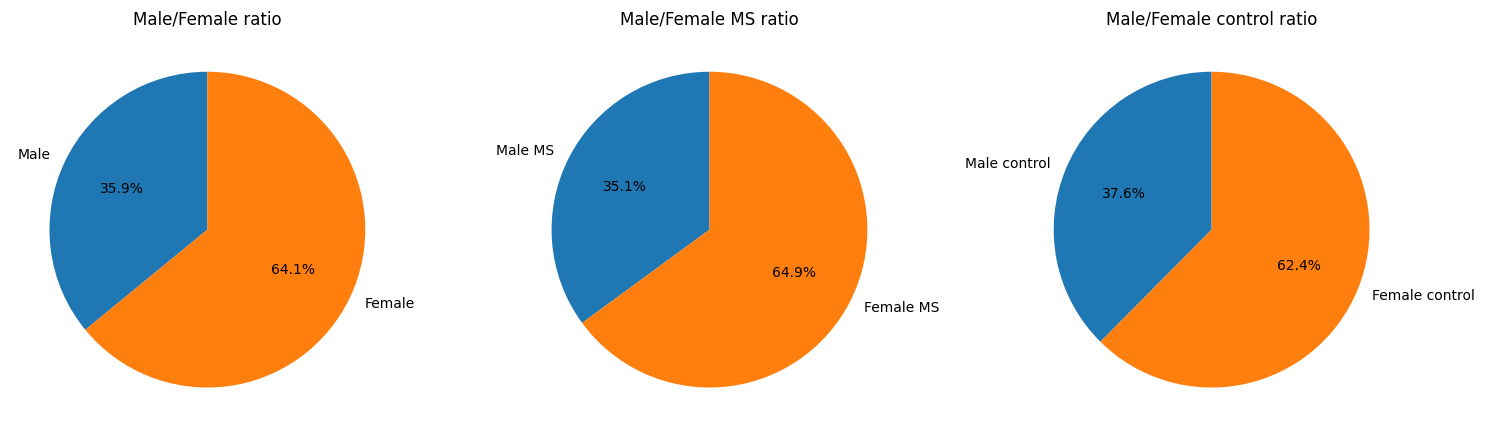

In [12]:
dataset['Gender'] = joblib.load('../Results/DatasetFull/genderFull.pkl')
dataset['Gender'] = dataset['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)
sexmap = dataset[['SampleID', 'Gender']].copy()
total_males = sexmap[sexmap['Gender'] == 1].shape[0]
total_females = sexmap[sexmap['Gender'] == 0].shape[0]

sick_df = sexmap[~sexmap['SampleID'].str.contains('Control')]

sick_males = sick_df[sick_df['Gender'] == 1].shape[0]
sick_females = sick_df[sick_df['Gender'] == 0].shape[0]

print("Numero totale di maschi:", total_males)
print("Numero totale di femmine:", total_females)
print("Numero di maschi Ms:", sick_males)
print("Numero di femmine Ms:", sick_females)
print("Numero di maschi Control:", total_males-sick_males)
print("Numero di femmine Control:", total_females-sick_females)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primo grafico a torta
axs[0].pie([total_males, total_females], labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Male/Female ratio')

# Secondo grafico a torta
axs[1].pie([sick_males, sick_females], labels=['Male MS', 'Female MS'], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Male/Female MS ratio')

# Terzo grafico a torta
axs[2].pie([total_males-sick_males, total_females-sick_females], labels=['Male control', 'Female control'], autopct='%1.1f%%', startangle=90)
axs[2].set_title('Male/Female control ratio')

# Aggiustiamo il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostriamo i grafici
plt.show()

<h2>Explorative data analysis</h2>

In [13]:
color = ['red', 'navy', 'grey', 'yellow', 'green', 'purple', 'pink', 'brown']
classiDataset = ['GSE41848', 'GSE41849', 'GSE146383', 'GSE13732', 'GSE136411', 'GSE17048', 'GSE41890', 'GSE21942']
classiLabel = ['Control', 'MS']
colorLabel = ['Black', 'Orange']
classiGender = ['Female', 'Male']
colorGender = ['Red', 'Blue']

<h3>Pre Combat</h3>

In [15]:
datasetPreCombat = pd.read_csv('MergedDatasetFull_symbol.csv')
datasetPreCombat['Gender'] = joblib.load('../Results/DatasetFull/genderFull.pkl')
datasetPreCombat

SampleID  Label       XPO6    ARPC1A  \
0                0-GSM1026056_600009.0001      1  11.650549  5.956854   
1     0-GSM1026057_600009.0001-FollowUp_1      1  11.868237  5.697745   
2                 0-GSM1026058_41461.0001      1  12.204048  6.588301   
3                 0-GSM1026059_41462.0001      1  12.176452  6.606812   
4                0-GSM1026060_600029.0001      1  12.151468  6.195992   
...                                   ...    ...        ...       ...   
1033                      7-GSM545842_M10      1   9.325217  8.476524   
1034                      7-GSM545843_M11      1   9.240105  8.279137   
1035           7-GSM545844_M11-FollowUp_1      1   9.348508  7.925483   
1036                      7-GSM545845_M12      1   9.150152  8.293933   
1037           7-GSM545846_M12-FollowUp_1      1   9.428572  7.966520   

         THOP1       CSTA        PKM    ZBTB25     STAM2     HCFC2  ...  \
0     7.162408   6.417070   9.921520  8.439175  8.046277  7.262682  ...   
1     7.424835   6.685321  10.243414  8.026961  7.708887  7.017581  ...   
2     7.326014   6.348511   9.966085  8.090392  7.964385  6.851573  ...   
3     7.162027   7.208305   9.979140  8.236338  8.329376  7.395053  ...   
4     7.083782   7.705152  10.225707  7.649344  8.295891  7.303182  ...   
...        ...        ...        ...       ...       ...       ...  ...   
1033  6.215869  11.247372  10.479694  6.933773  7.395533  6.510352  ...   
1034  5.773038  11.246373   9.645089  7.198303  7.670106  6.765494  ...   
1035  5.735498  11.318210   9.527473  7.249451  7.634948  6.668680  ...   
1036  5.593354  11.183782   9.740226  7.398097  7.869972  6.662122  ...   
1037  5.740724  11.205737   9.805391  7.544257  7.698504  6.655938  ...   

         CERS4     SMCO4   TMEM260   LAMTOR3    ACTL6A     MS4A6A     BAZ2A  \
0     7.326748  6.335905  8.110225  8.102131  6.348476   8.500851  8.825179   
1     7.539136  6.124359  7.878257  8.120959  6.256685   8.546182  9.181231   
2     7.519021  7.042481  8.187341  7.942987  6.254222   8.844696  9.155631   
3     7.435640  6.360349  8.674475  8.697892  6.409212   9.180507  9.190014   
4     7.412286  6.673139  8.473277  8.457575  6.421640   9.398804  9.362108   
...        ...       ...       ...       ...       ...        ...       ...   
1033  4.944003  8.900831  7.559928  9.129791  7.374601  10.937702  7.659700   
1034  5.435732  9.073892  7.367424  9.228510  8.381170  10.820722  7.137152   
1035  5.347068  9.270401  7.988876  9.268521  8.231973  10.698401  7.404353   
1036  4.880152  9.099389  7.532096  9.390753  8.217098  10.725866  7.098828   
1037  4.854416  9.319003  8.120988  9.351598  8.249196  10.799216  7.486778   

          TPM1      OSTF1  Gender  
0     7.069051   9.823801  Female  
1     6.840454  10.063447  Female  
2     7.067990  10.610273  Female  
3     7.263440  10.546718  Female  
4     6.928783  10.760723  Female  
...        ...        ...     ...  
1033  8.224351   8.686298  Female  
1034  7.823008   8.726589  Female  
1035  8.017363   8.692620  Female  
1036  8.318048   8.563869  Female  
1037  8.301014   8.680367  Female  

[1038 rows x 6676 columns]

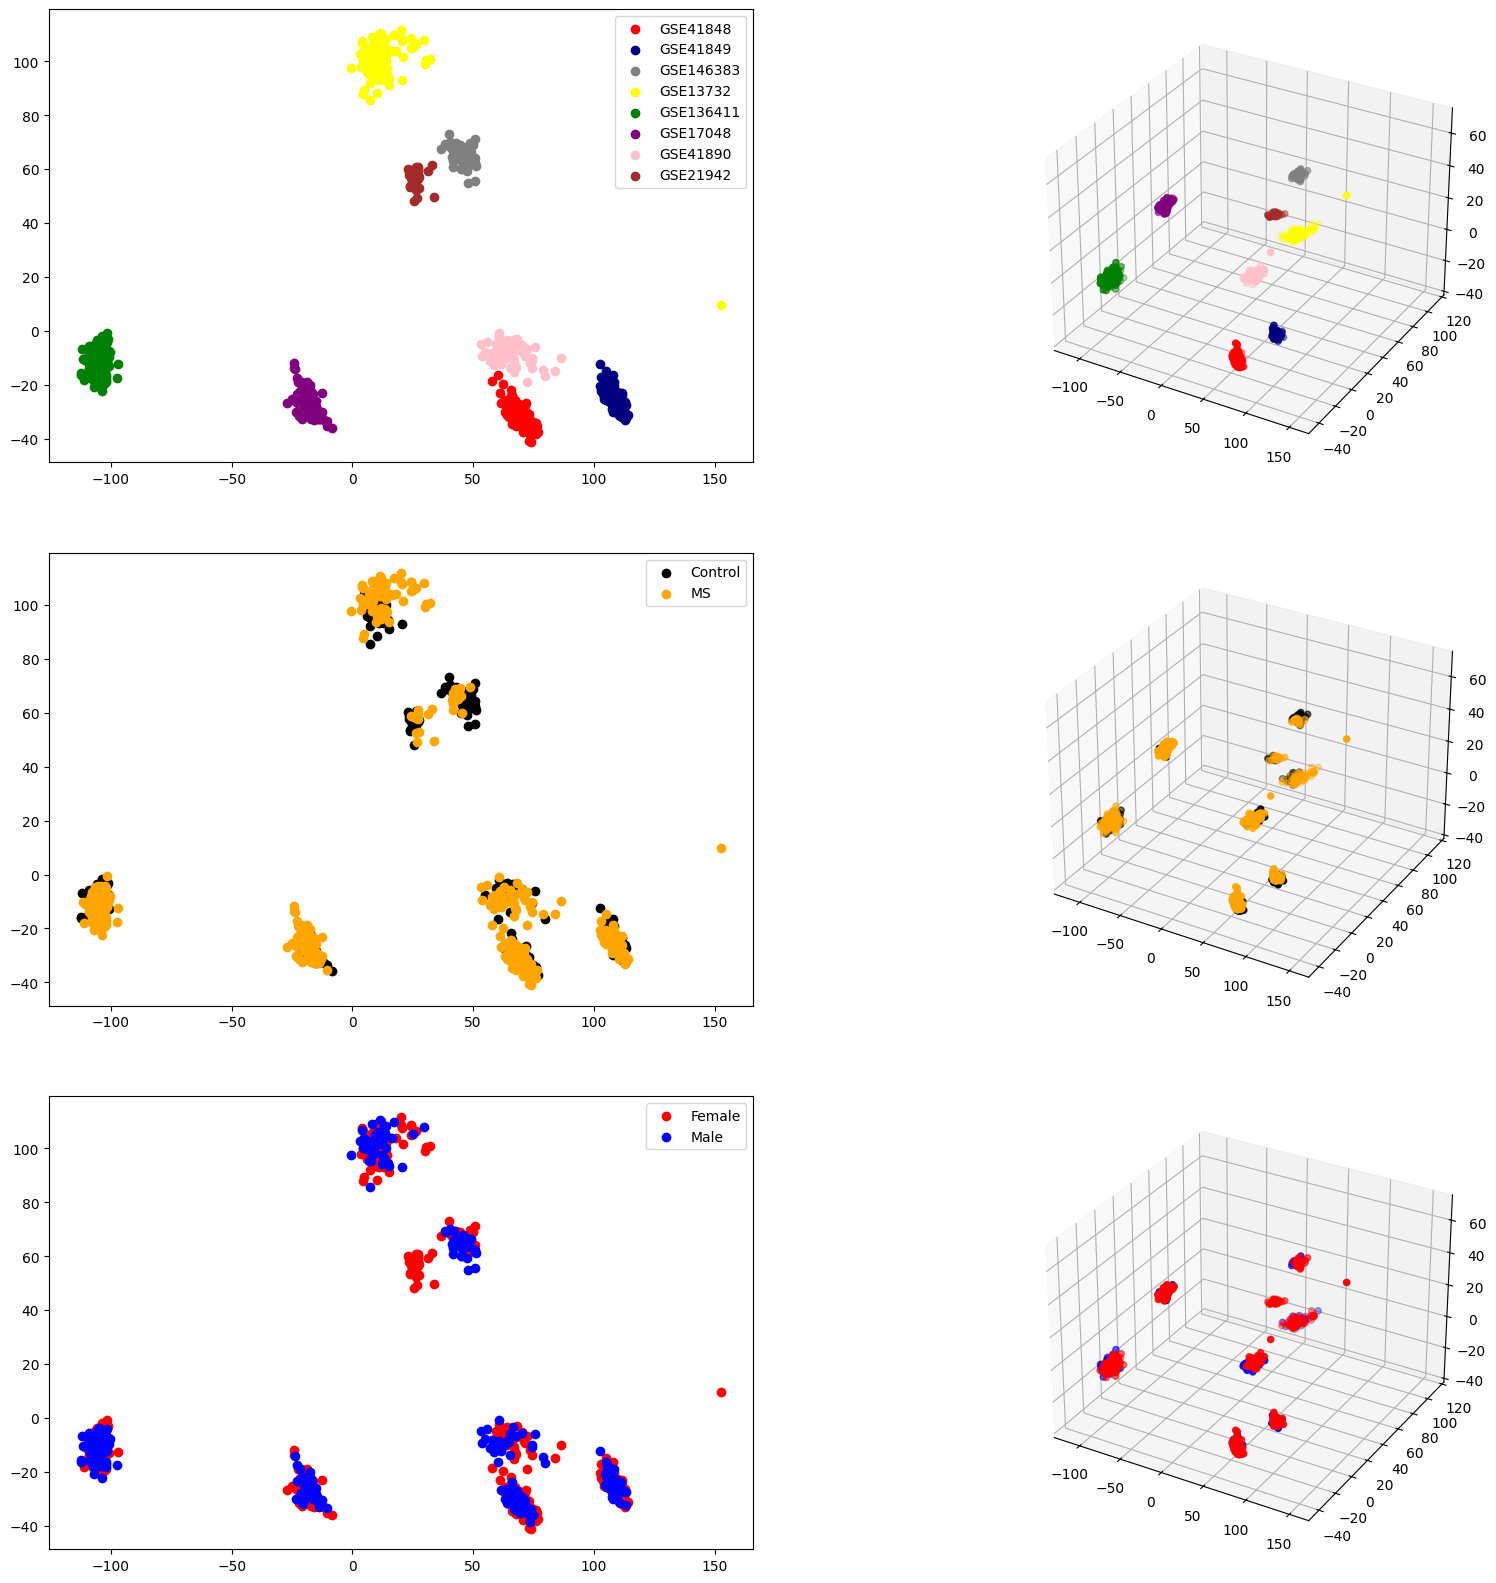

In [16]:
current = datasetPreCombat.copy()
current['Gender'] = current['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)
currentGender = current['Gender']
current.drop(columns=['SampleID', 'Label'], inplace=True)

pca = PCA(n_components=2).fit_transform(current)
pca3 = PCA(n_components=3).fit_transform(current)

fig = plt.figure(figsize=(20, 20))

plot1 = fig.add_subplot(321)
plot2 = fig.add_subplot(322, projection='3d')
plot3 = fig.add_subplot(323)
plot4 = fig.add_subplot(324, projection='3d')
plot5 = fig.add_subplot(325)
plot6 = fig.add_subplot(326, projection='3d')

for i in range(8):
    plot1.scatter(pca[datasetID == str(i)][:, 0], pca[datasetID == str(i)][:, 1], c=color[i], label=classiDataset[i])
    plot2.scatter(pca3[datasetID == str(i)][:, 0], pca3[datasetID == str(i)][:, 1], pca3[datasetID == str(i)][:, 2], c=color[i], label=classiDataset[i])

for i in range(0, 2):
    plot3.scatter(pca[label == i][:, 0], pca[label == i][:, 1], c=colorLabel[i], label=classiLabel[i])
    plot4.scatter(pca3[label == i][:, 0], pca3[label == i][:, 1], pca3[label == i][:, 2], c=colorLabel[i], label=classiLabel[i])

for i in range(0, 2):
    plot5.scatter(pca[currentGender == i][:, 0], pca[currentGender == i][:, 1], c=colorGender[i], label=classiGender[i])
    plot6.scatter(pca3[currentGender == i][:, 0], pca3[currentGender == i][:, 1], pca3[currentGender == i][:, 2], c=colorGender[i], label=classiGender[i])

plot1.legend()
plot3.legend()
plot5.legend()
plt.show()

<h3>Post Combat</h3>

In [17]:
dataset = pd.read_csv('MergedDatasetFullCombat_symbol.csv')
dataset['Gender'] = joblib.load('../Results/DatasetFull/genderFull.pkl')
dataset['Gender'] = dataset['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)
dataset

SampleID  Label     TRAK2   MARCHF5  \
0                0-GSM1026056_600009.0001      1  9.597071  6.172613   
1     0-GSM1026057_600009.0001-FollowUp_1      1  9.039251  6.532620   
2                 0-GSM1026058_41461.0001      1  8.791386  6.548371   
3                 0-GSM1026059_41462.0001      1  9.373170  7.116801   
4                0-GSM1026060_600029.0001      1  9.076237  7.104757   
...                                   ...    ...       ...       ...   
1033                      7-GSM545842_M10      1  8.955028  6.642111   
1034                      7-GSM545843_M11      1  9.101329  6.715089   
1035           7-GSM545844_M11-FollowUp_1      1  9.271382  6.670915   
1036                      7-GSM545845_M12      1  9.351712  6.679360   
1037           7-GSM545846_M12-FollowUp_1      1  9.292476  6.678637   

          AVIL    CLSTN1    TAPBPL     TRIM38     GDF11    TBXA2R  ...  \
0     6.183003  7.619254  8.451946   9.674435  6.629841  6.700156  ...   
1     6.350718  7.841904  8.629886   9.565077  6.824635  6.727150  ...   
2     6.933703  7.279164  8.166420   9.772884  6.515736  6.363606  ...   
3     7.012218  7.233344  8.338171   9.725869  6.458866  6.108414  ...   
4     6.515409  7.488312  8.355218  10.033820  6.189225  6.473050  ...   
...        ...       ...       ...        ...       ...       ...  ...   
1033  6.639887  7.445428  8.359939   9.682368  6.735513  6.554890  ...   
1034  6.611748  7.449074  8.112262   9.634445  6.503292  6.350074  ...   
1035  6.620238  7.404586  8.119619   9.650254  6.681918  6.342317  ...   
1036  6.581669  7.442222  8.282929   9.638524  6.409742  6.433034  ...   
1037  6.662260  7.397570  8.343229   9.653412  6.024943  6.410587  ...   

       PAK1IP1     NDUFA1      PEX7      NET1     TMED5      FADD     URGCP  \
0     7.339375  10.188925  6.535162  7.816546  9.744325  8.263995  7.352167   
1     7.251840  10.255465  6.432247  7.916046  9.687447  8.241698  7.349809   
2     7.279236  10.101372  6.495679  8.104559  9.632676  8.242744  7.205897   
3     7.311252  10.314306  6.353293  7.386301  9.769748  8.376067  7.312015   
4     7.289160  10.243407  6.334131  7.331289  9.626407  8.217957  7.254979   
...        ...        ...       ...       ...       ...       ...       ...   
1033  7.015461  10.312671  5.698647  7.380776  9.698418  8.155223  7.361099   
1034  7.259678  10.357670  6.671623  7.428976  9.763741  8.122246  7.262578   
1035  7.351145  10.208762  6.715863  7.705067  9.785031  8.103883  7.362873   
1036  7.178289  10.401224  6.861365  7.413546  9.703183  8.135620  7.244212   
1037  7.309705  10.255236  6.813299  7.595989  9.750070  8.454906  7.257439   

          MDM4    BMPR1A  Gender  
0     8.662674  6.263145       0  
1     8.445578  7.242537       0  
2     8.071700  6.124447       0  
3     8.425182  6.534315       0  
4     7.917974  6.195773       0  
...        ...       ...     ...  
1033  8.327890  6.361955       0  
1034  8.175908  7.282642       0  
1035  8.131763  7.425195       0  
1036  8.187447  6.908857       0  
1037  8.178654  6.913615       0  

[1038 rows x 6676 columns]

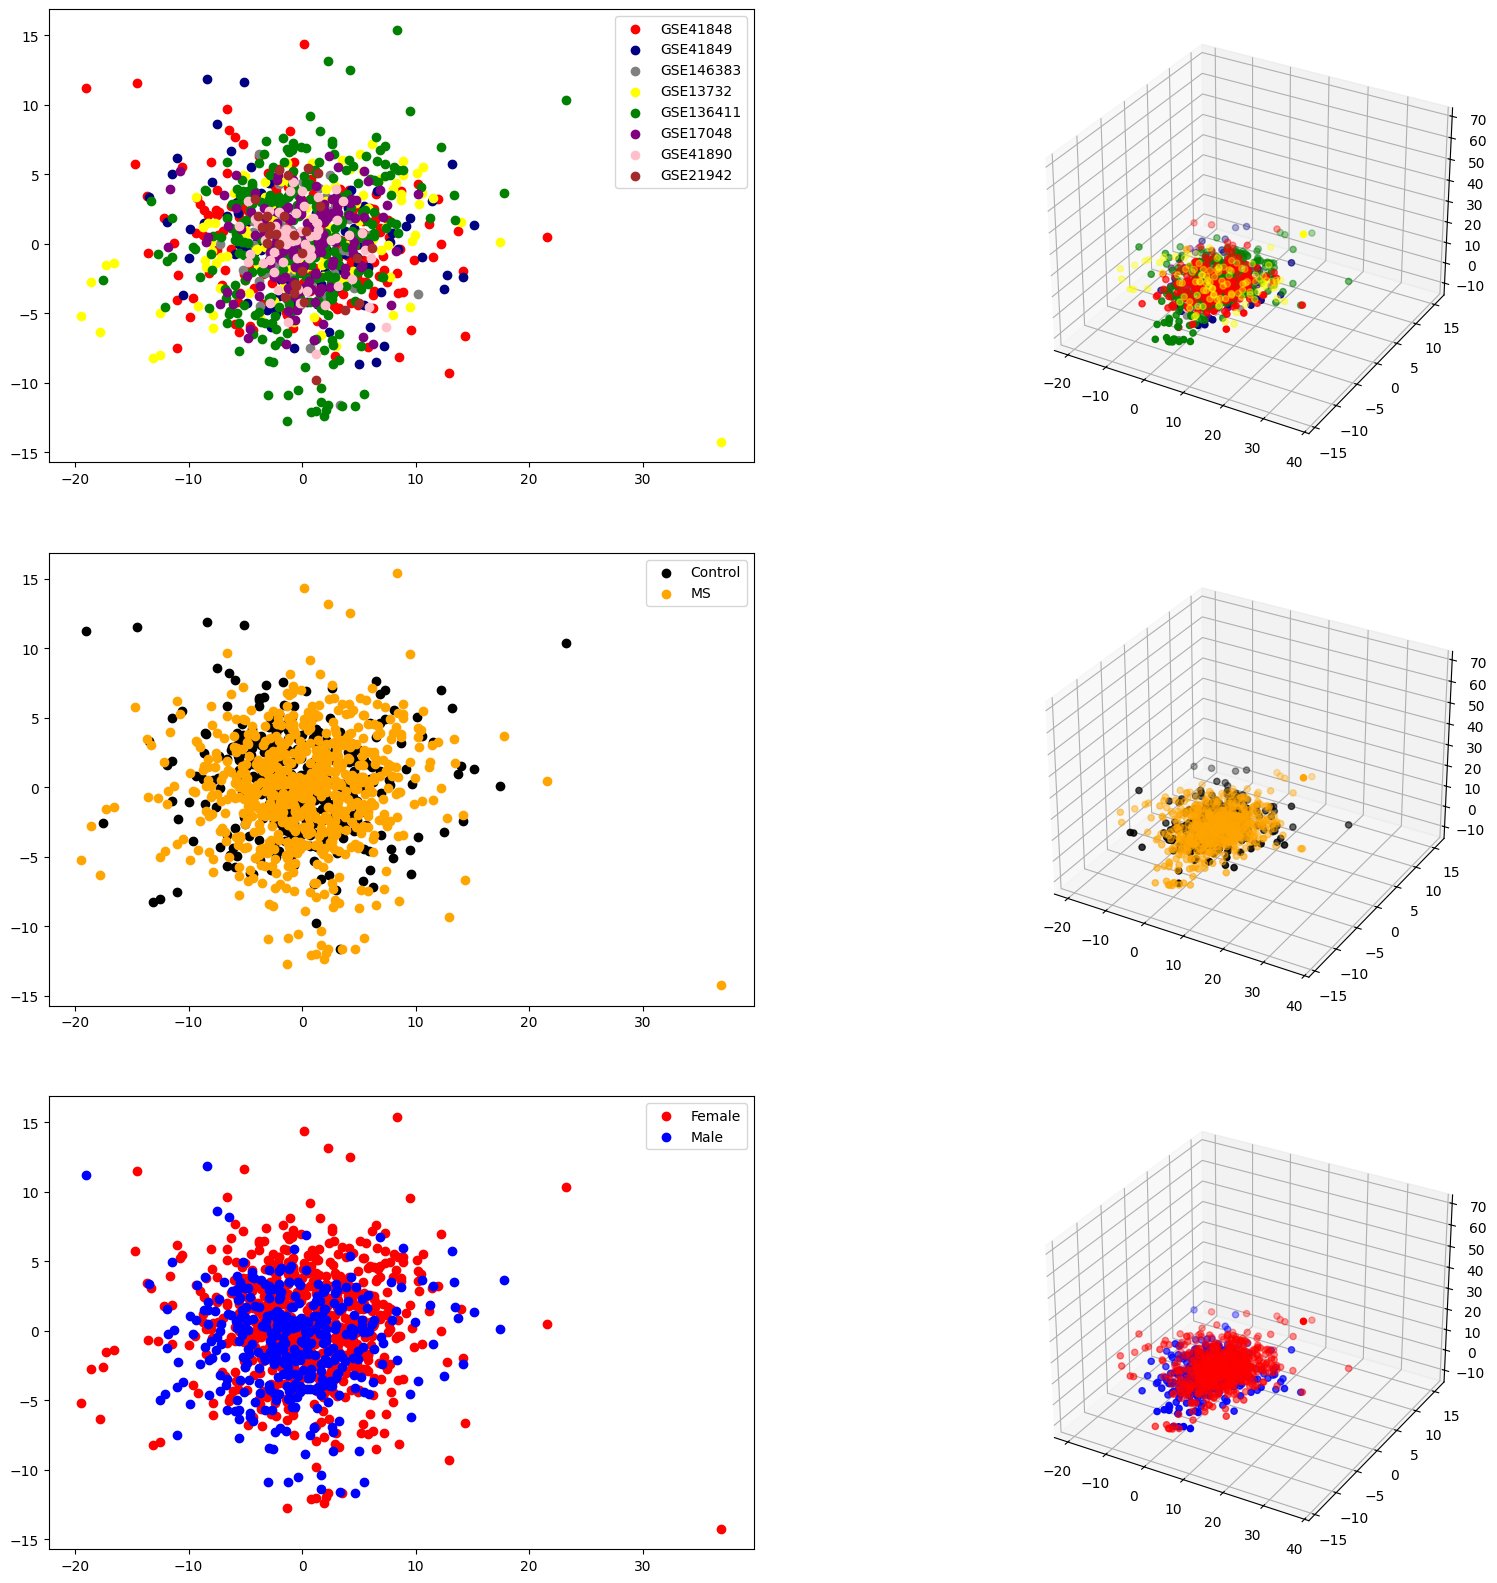

In [18]:
current = dataset.copy()
currentGender = current['Gender']
current.drop(columns=['SampleID', 'Label'], inplace=True)

pca = PCA(n_components=2).fit_transform(current)
pca3 = PCA(n_components=3).fit_transform(current)

fig = plt.figure(figsize=(20, 20))

plot1 = fig.add_subplot(321)
plot2 = fig.add_subplot(322, projection='3d')
plot3 = fig.add_subplot(323)
plot4 = fig.add_subplot(324, projection='3d')
plot5 = fig.add_subplot(325)
plot6 = fig.add_subplot(326, projection='3d')

for i in range(8):
    plot1.scatter(pca[datasetID == str(i)][:, 0], pca[datasetID == str(i)][:, 1], c=color[i], label=classiDataset[i])
    plot2.scatter(pca3[datasetID == str(i)][:, 0], pca3[datasetID == str(i)][:, 1], pca3[datasetID == str(i)][:, 2], c=color[i], label=classiDataset[i])

for i in range(0, 2):
    plot3.scatter(pca[label == i][:, 0], pca[label == i][:, 1], c=colorLabel[i], label=classiLabel[i])
    plot4.scatter(pca3[label == i][:, 0], pca3[label == i][:, 1], pca3[label == i][:, 2], c=colorLabel[i], label=classiLabel[i])

for i in range(0, 2):
    plot5.scatter(pca[currentGender == i][:, 0], pca[currentGender == i][:, 1], c=colorGender[i], label=classiGender[i])
    plot6.scatter(pca3[currentGender == i][:, 0], pca3[currentGender == i][:, 1], pca3[currentGender == i][:, 2], c=colorGender[i], label=classiGender[i])

plot1.legend()
plot3.legend()
plot5.legend()
plt.show()

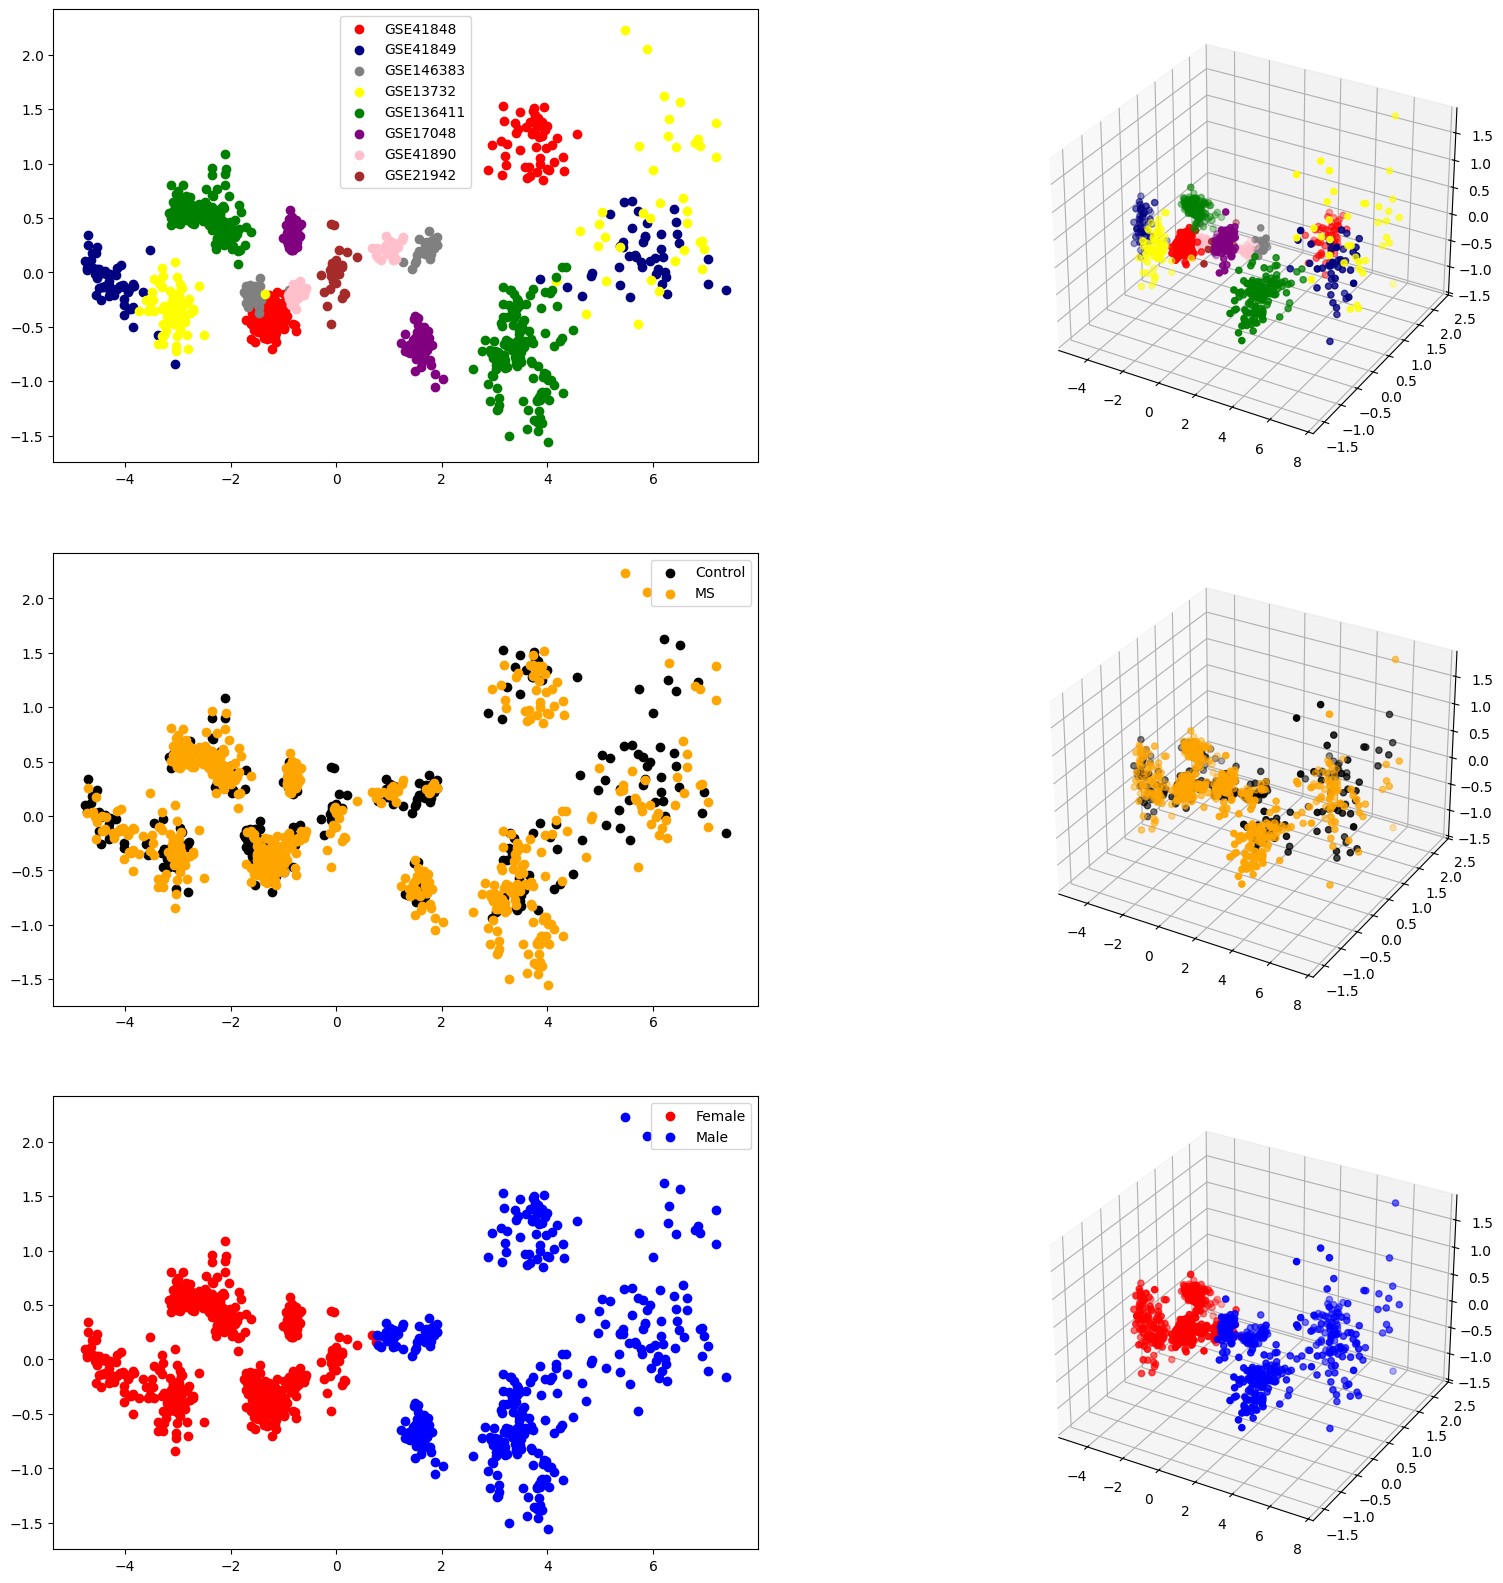

In [19]:
y_linked_genes = pd.read_csv("../../../Dataset/Y_linked_genes.txt", sep=',')

current = dataset.copy()
currentGender = current['Gender']

common_y_genes = list(y_linked_genes[y_linked_genes['HGNC symbol'].isin(current.columns)]['HGNC symbol'])
currentY = current[common_y_genes]

pca = PCA(n_components=2).fit_transform(currentY)
pca3 = PCA(n_components=3).fit_transform(currentY)

fig = plt.figure(figsize=(20, 20))

plot1 = fig.add_subplot(321)
plot2 = fig.add_subplot(322, projection='3d')
plot3 = fig.add_subplot(323)
plot4 = fig.add_subplot(324, projection='3d')
plot5 = fig.add_subplot(325)
plot6 = fig.add_subplot(326, projection='3d')

for i in range(8):
    plot1.scatter(pca[datasetID == str(i)][:, 0], pca[datasetID == str(i)][:, 1], c=color[i], label=classiDataset[i])
    plot2.scatter(pca3[datasetID == str(i)][:, 0], pca3[datasetID == str(i)][:, 1], pca3[datasetID == str(i)][:, 2], c=color[i], label=classiDataset[i])

for i in range(0, 2):
    plot3.scatter(pca[label == i][:, 0], pca[label == i][:, 1], c=colorLabel[i], label=classiLabel[i])
    plot4.scatter(pca3[label == i][:, 0], pca3[label == i][:, 1], pca3[label == i][:, 2], c=colorLabel[i], label=classiLabel[i])

for i in range(0, 2):
    plot5.scatter(pca[currentGender == i][:, 0], pca[currentGender == i][:, 1], c=colorGender[i], label=classiGender[i])
    plot6.scatter(pca3[currentGender == i][:, 0], pca3[currentGender == i][:, 1], pca3[currentGender == i][:, 2], c=colorGender[i], label=classiGender[i])

plot1.legend()
plot3.legend()
plot5.legend()
plt.show()

<h1>Analisi dei geni poorly corrected</h1>

Utils

In [ ]:
def computeMixtureScore(datasets, labels, k):
    combinedData = np.vstack(list(datasets))

    with parallel_backend('threading', n_jobs=1):
        knn = NearestNeighbors(n_neighbors=k)
        knn.fit(combinedData)
        _, indices = knn.kneighbors(combinedData)
    
    mixture = 0
    for x in range(0,datasets[0].shape[0]):
        neighbors = indices[x]
        mixture += sum(labels[neighbors] != labels[x])

    mixture_score = mixture / (k * datasets[0].shape[0])
    return mixture_score

def mixtureScore(data, k):
    permutations = list(itertools.combinations(list(set(data['DatasetID'])), 2))

    results = {}

    for perm in permutations:
        data1 = data[data['DatasetID'] == perm[0]]
        data2 = data[data['DatasetID'] == perm[1]]

        dataID = pd.Series.combine_first(data1['DatasetID'], data2['DatasetID']).values

        data1 = data1.drop(columns=['DatasetID', 'SampleID', 'Label', 'Gender'])
        data2 = data2.drop(columns=['DatasetID', 'SampleID', 'Label', 'Gender'])

        if k > data2.shape[0]:
            temp_k = round(data2.shape[0]/2)
            print("K is too large, setting it to ", temp_k)

            results[perm] = computeMixtureScore([data1, data2], dataID, temp_k)
        else:
            results[perm] = computeMixtureScore([data1, data2], dataID, k)

    return results

def diffExpr(data):
    permutations = list(itertools.combinations(list(set(datasetID)), 2))

    result = {}

    for perm in permutations:
        data1 = data[data['DatasetID'] == perm[0]]
        data2 = data[data['DatasetID'] == perm[1]]

        data1.drop(columns=['DatasetID'], inplace=True)
        data2.drop(columns=['DatasetID'], inplace=True)

        genes = tuple(data1.columns)

        statistic, p_value = mannwhitneyu(data1, data2)
        boolean, p_value_corrected = fdrcorrection(p_value, alpha=0.05)

        deGenes = {genes: [statistic, p_value, boolean, p_value_corrected]}
        
        result[perm] = deGenes 
    
    return result

#La funzione restituisce un dizionario con chiavi le coppie di dataset e valori una lista con statistiche, p-value, booleano se il p-value è significativo e p-value corretto 

def biModality(dataset):
    variances = dataset.var(axis=0)
    # p_values = dataset.apply(lambda x: ks_1samp(x, cdf=norm.cdf)[1], axis=0)
    p_values = pd.Series(index=dataset.columns)
    for gene in dataset.columns:
        p_values.loc[gene] = diptest(dataset[gene])[1]

    threshold_var = np.percentile(variances, 50)  # Soglia: top 50% varianza
    list_multiModalGenes = list(dataset.columns[(variances > threshold_var) & (p_values < 0.05)])
    # list_multiModalGenes = list(dataset.columns[(p_values < 0.05)])

    return list_multiModalGenes

def multiModality(dataset):
    optimal_components = {}
    for gene in dataset.columns:
        bic_scores = []
        for n in range(1, 6):
            gmm = GaussianMixture(n_components=n, random_state=0).fit(dataset[gene].values.reshape(-1, 1))
            bic_scores.append(gmm.bic(dataset[gene].values.reshape(-1, 1)))

        optimal_components[gene] = bic_scores.index(min(bic_scores)) + 1
    return optimal_components

In [21]:
dataset = pd.read_csv('MergedDatasetFullCombat_symbol.csv')
dataset['Gender'] = joblib.load('../Results/DatasetFull/genderFull.pkl')
dataset['Gender'] = dataset['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
sampleID = dataset['SampleID']
label = dataset['Label']
gender = dataset['Gender']

<h2>Mixture score</h2>

In [23]:
current = dataset.copy()

current['DatasetID'] = datasetID
currentMS = current[current['Label'] == 1]
currentControl = current[current['Label'] == 0]

scoreMS = mixtureScore(currentMS, 30)
scoreControl = mixtureScore(currentControl, 30)

avgMS_score = np.mean(list(scoreMS.values()))
avgControl_score = np.mean(list(scoreControl.values()))

print("MS Mixture Score: ", avgMS_score)
print("Control Mixture Score: ", avgControl_score)

K is too large, setting it to  7
K is too large, setting it to  8
K is too large, setting it to  8
K is too large, setting it to  8
K is too large, setting it to  8
K is too large, setting it to  12
K is too large, setting it to  12
MS Mixture Score:  0.260480185139832
Control Mixture Score:  0.3054518626029617


<h2>Geni differenzialmente espressi tra dataset</h2>

DE tra dataset sui sani

In [24]:
warnings.filterwarnings("ignore")
current = dataset.copy()
current.drop(columns=['SampleID', 'Label'], inplace=True)
current['DatasetID'] = datasetID
currentControl = current[label == 0]

results = diffExpr(currentControl)

deGenes = set()

first = True

for key, value in results.items():
    genes = list(list(value.keys())[0])
    singleResult = list(value.values())
    resultDf = pd.DataFrame({'statistic': singleResult[0][0], 'p-value': singleResult[0][1], 'significant': singleResult[0][2], 'p-value corrected': singleResult[0][3]})
    resultDf.index = genes

    # resultDf['significant'] = resultDf['p-value'] < 0.05

    currentDeGenesControl = set(resultDf[resultDf['significant']].index)

    if first == True:
        deGenesControl = currentDeGenesControl
        first = False
    else: deGenesControl = deGenesControl.intersection(currentDeGenesControl)

print(len(deGenesControl), deGenesControl)

0 set()


DE tra dataset sui malati

In [25]:
warnings.filterwarnings("ignore")

current = dataset.copy()
current.drop(columns=['SampleID', 'Label'], inplace=True)
current['DatasetID'] = datasetID
currentMS = current[label == 1]

results = diffExpr(currentMS)

deGenes = set()

first = True

for key, value in results.items():
    genes = list(list(value.keys())[0])
    singleResult = list(value.values())
    resultDf = pd.DataFrame({'statistic': singleResult[0][0], 'p-value': singleResult[0][1], 'significant': singleResult[0][2], 'p-value corrected': singleResult[0][3]})
    resultDf.index = genes

    # resultDf['significant'] = resultDf['p-value'] < 0.05

    currentDeGenesMs = set(resultDf[resultDf['significant']].index)

    if first == True:
        deGenesMs = currentDeGenesMs
        first = False
    else: deGenesMs = deGenesMs.intersection(currentDeGenesMs)

print(len(deGenesMs), deGenesMs)

0 set()


Geni DE tra dataset comuni ai due gruppi

In [26]:
commonDeGenes = deGenesControl.intersection(deGenesMs)
print(len(commonDeGenes), commonDeGenes)

0 set()


In [ ]:
current = dataset.copy()

current['Gender'] = current['Gender'].apply(lambda x: 'Male' if x == 1 else 'Female')
current['disease'] = current['Label'].apply(lambda x: 'MS' if x == 1 else 'Control')
current['diff'] = current['Gender']+"-"+current['disease'].astype(str)
current['DatasetID'] = datasetID

gene_list = list(commonDeGenes)

fig, axes = plt.subplots(len(gene_list), 3, figsize=(40, 40))

for i, gene in enumerate(gene_list):
    sns.histplot(data=current, x=gene, hue='diff', stat="probability",
                 kde=True, palette={'Female-MS':'orange', 'Female-Control':'red', 'Male-MS':'green', 'Male-Control':'blue'}, multiple='dodge', common_norm=False, ax=axes[i][0])
    axes[i][0].set_title(gene)
    axes[i][0].set_xlabel("Gene Expression Level")
    axes[i][0].set_ylabel("Density")


    sns.histplot(data=current, x=gene, hue='disease', stat="probability",
                 kde=True, palette={'Control': 'grey', 'MS': 'orange'}, multiple='dodge', common_norm=False, ax=axes[i][1])
    axes[i][1].set_title('Control vs MS')
    axes[i][1].set_xlabel("Gene Expression Level")
    axes[i][1].set_ylabel("Density")

    sns.histplot(data=current, x=gene, hue='DatasetID', stat="probability",
                 kde=True, palette={'0':'orange', '1':'red', '2':'green', '3':'blue', '4':'yellow', '5':'black'}, multiple='dodge', common_norm=False, ax=axes[i][2])
    axes[i][2].set_title(gene)
    axes[i][2].set_xlabel("Gene Expression Level")
    axes[i][2].set_ylabel("Density")

    plt.subplots_adjust(hspace=0.5)

plt.suptitle("Espressione dei geni DE tra dataset comuni alle due condizioni", fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

<h2>MultiModalità</h2>

I test di multimodalità vengono eseguiti per ogni gene sui sample appartenenti agli stessi gruppi biologici in modo da evitare che la condizione non influenzi il rilevamento di batch effect residui

In [27]:
current = dataset.copy()
current.drop(columns=['SampleID', 'Label', 'Gender'], inplace=True)
currentMS = current[label == 1]
currentControl = current[label == 0]

bimodalMS = biModality(currentMS)
bimodalControl = biModality(currentControl)

In [28]:
commonBimodal = set(bimodalMS).union(set(bimodalControl))
print(len(commonBimodal), commonBimodal)

11 {'PRKY', 'HLA-DRB1', 'TMSB4Y', 'RPS21', 'HLA-DRB5', 'ZNF549', 'RPS4Y1', 'DDX3Y', 'UTY', 'EIF1AY', 'TXLNGY'}


Plot solo sui sample di cui conosco esattamente il genere

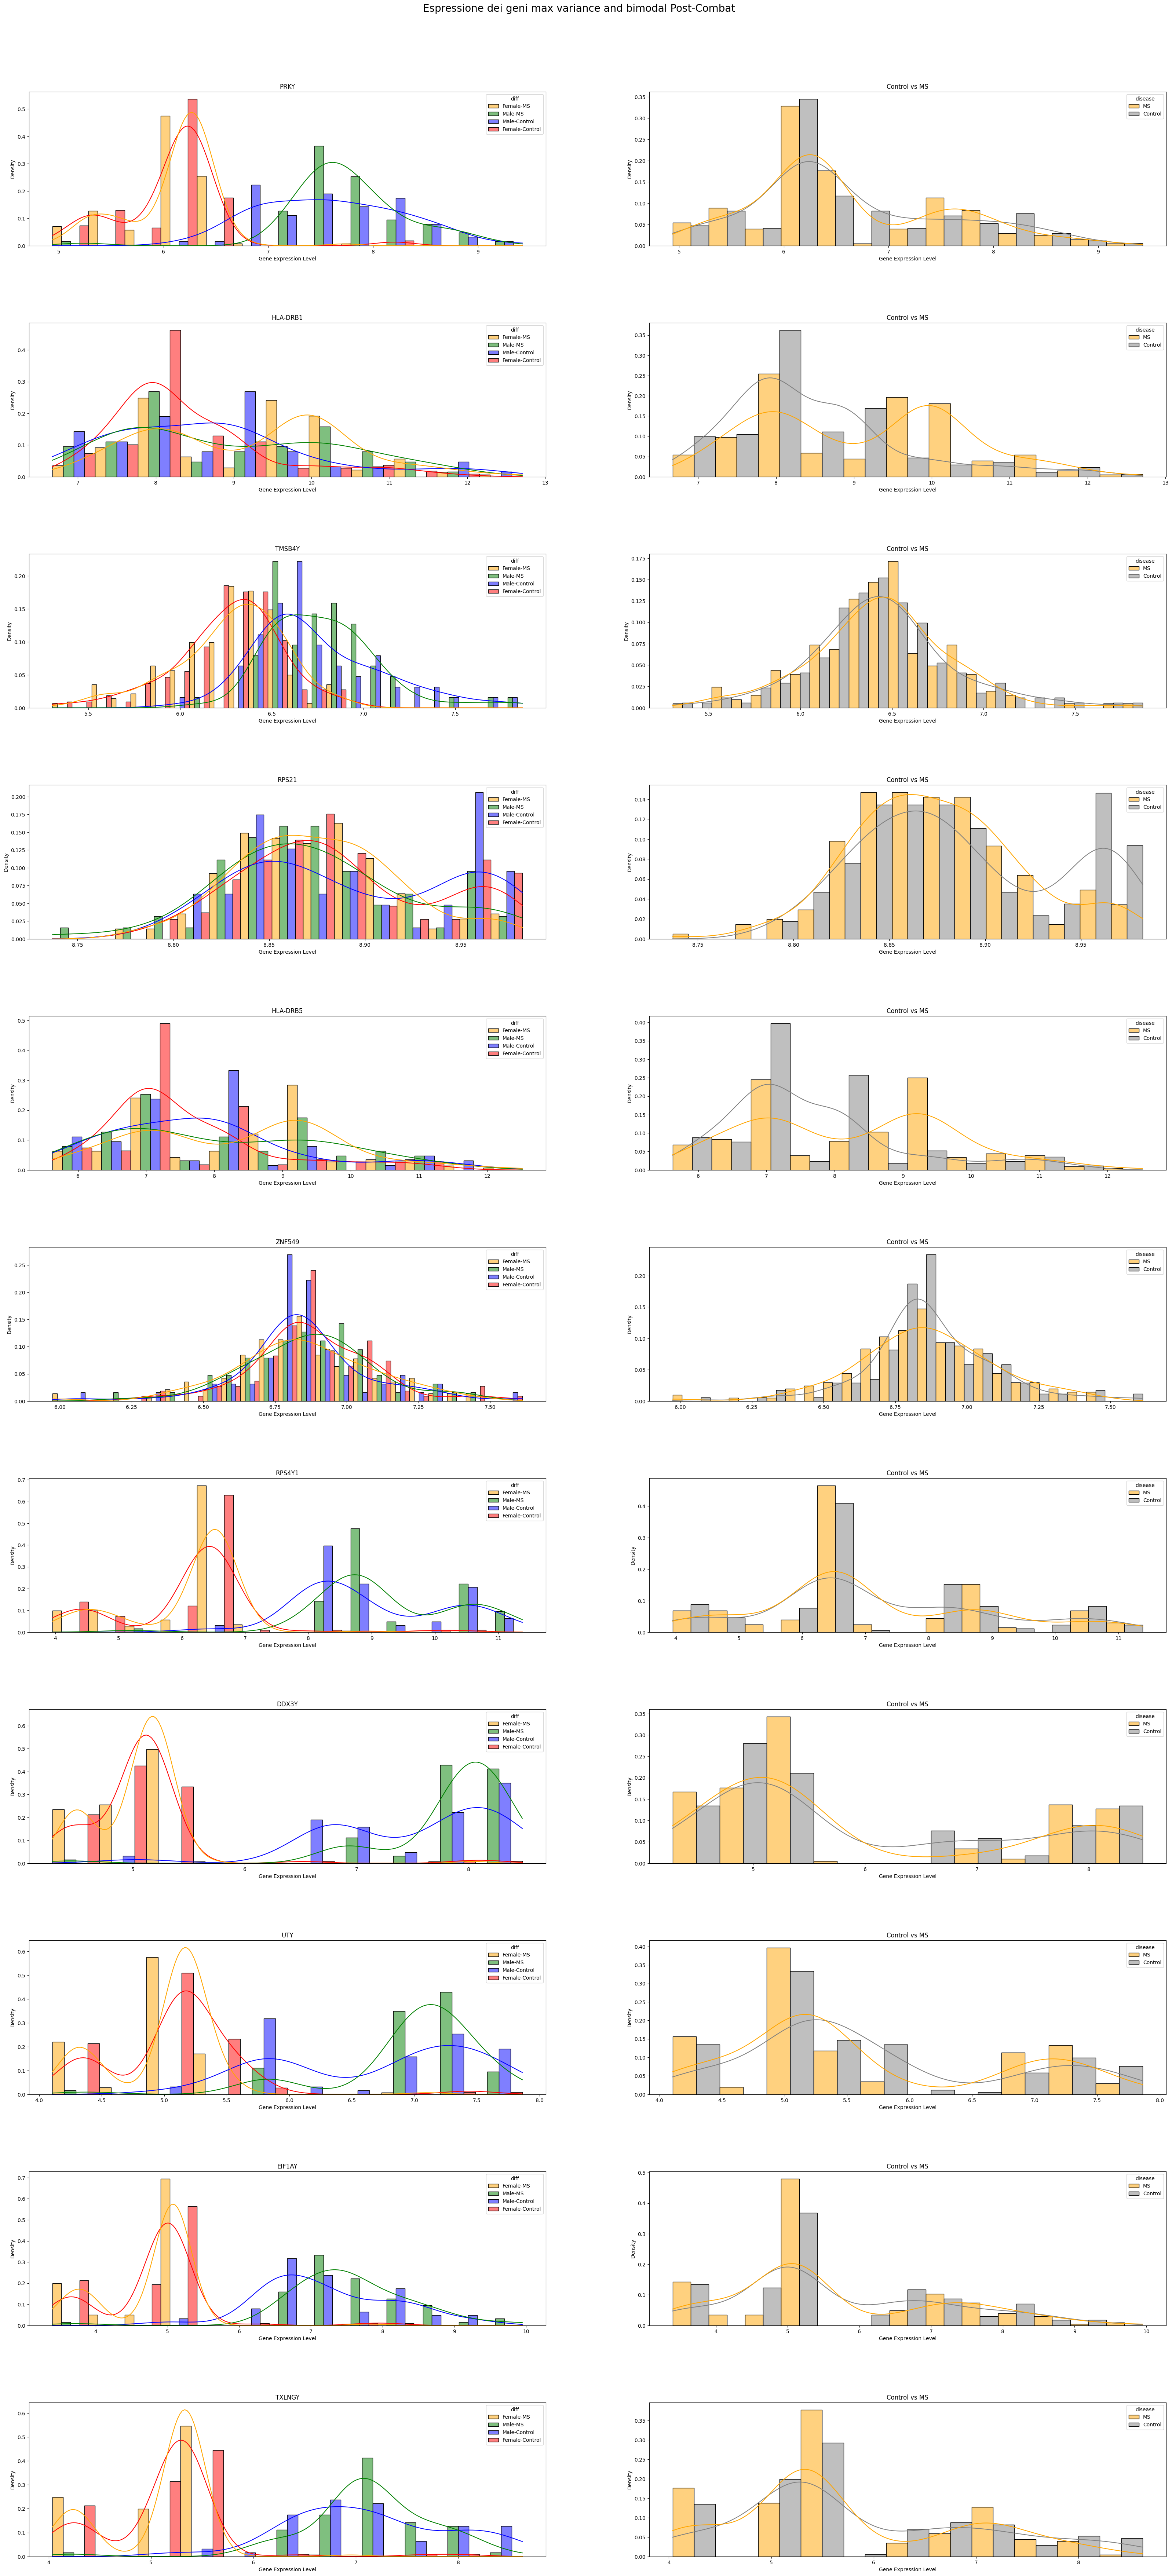

In [32]:
current = datasetGenderExact.copy()
current['Gender'] = current['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)
current['Gender'] = current['Gender'].apply(lambda x: 'Male' if x == 1 else 'Female')
current['disease'] = current['Label'].apply(lambda x: 'MS' if x == 1 else 'Control')
current['diff'] = current['Gender']+"-"+current['disease'].astype(str)
current['DatasetID'] = current['SampleID'].apply(lambda x: x.split('-')[0])

gene_list = list(commonBimodal)

fig, axes = plt.subplots(len(gene_list), 2, figsize=(40, 80))

for i, gene in enumerate(gene_list):
    sns.histplot(data=current, x=gene, hue='diff', stat="probability",
                 kde=True, palette={'Female-MS':'orange', 'Female-Control':'red', 'Male-MS':'green', 'Male-Control':'blue'}, multiple='dodge', common_norm=False, ax=axes[i][0])
    axes[i][0].set_title(gene)
    axes[i][0].set_xlabel("Gene Expression Level")
    axes[i][0].set_ylabel("Density")


    sns.histplot(data=current, x=gene, hue='disease', stat="probability",
                 kde=True, palette={'Control': 'grey', 'MS': 'orange'}, multiple='dodge', common_norm=False, ax=axes[i][1])
    axes[i][1].set_title('Control vs MS')
    axes[i][1].set_xlabel("Gene Expression Level")
    axes[i][1].set_ylabel("Density")

    plt.subplots_adjust(hspace=0.5)

plt.suptitle("Espressione dei geni max variance and bimodal Post-Combat", fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

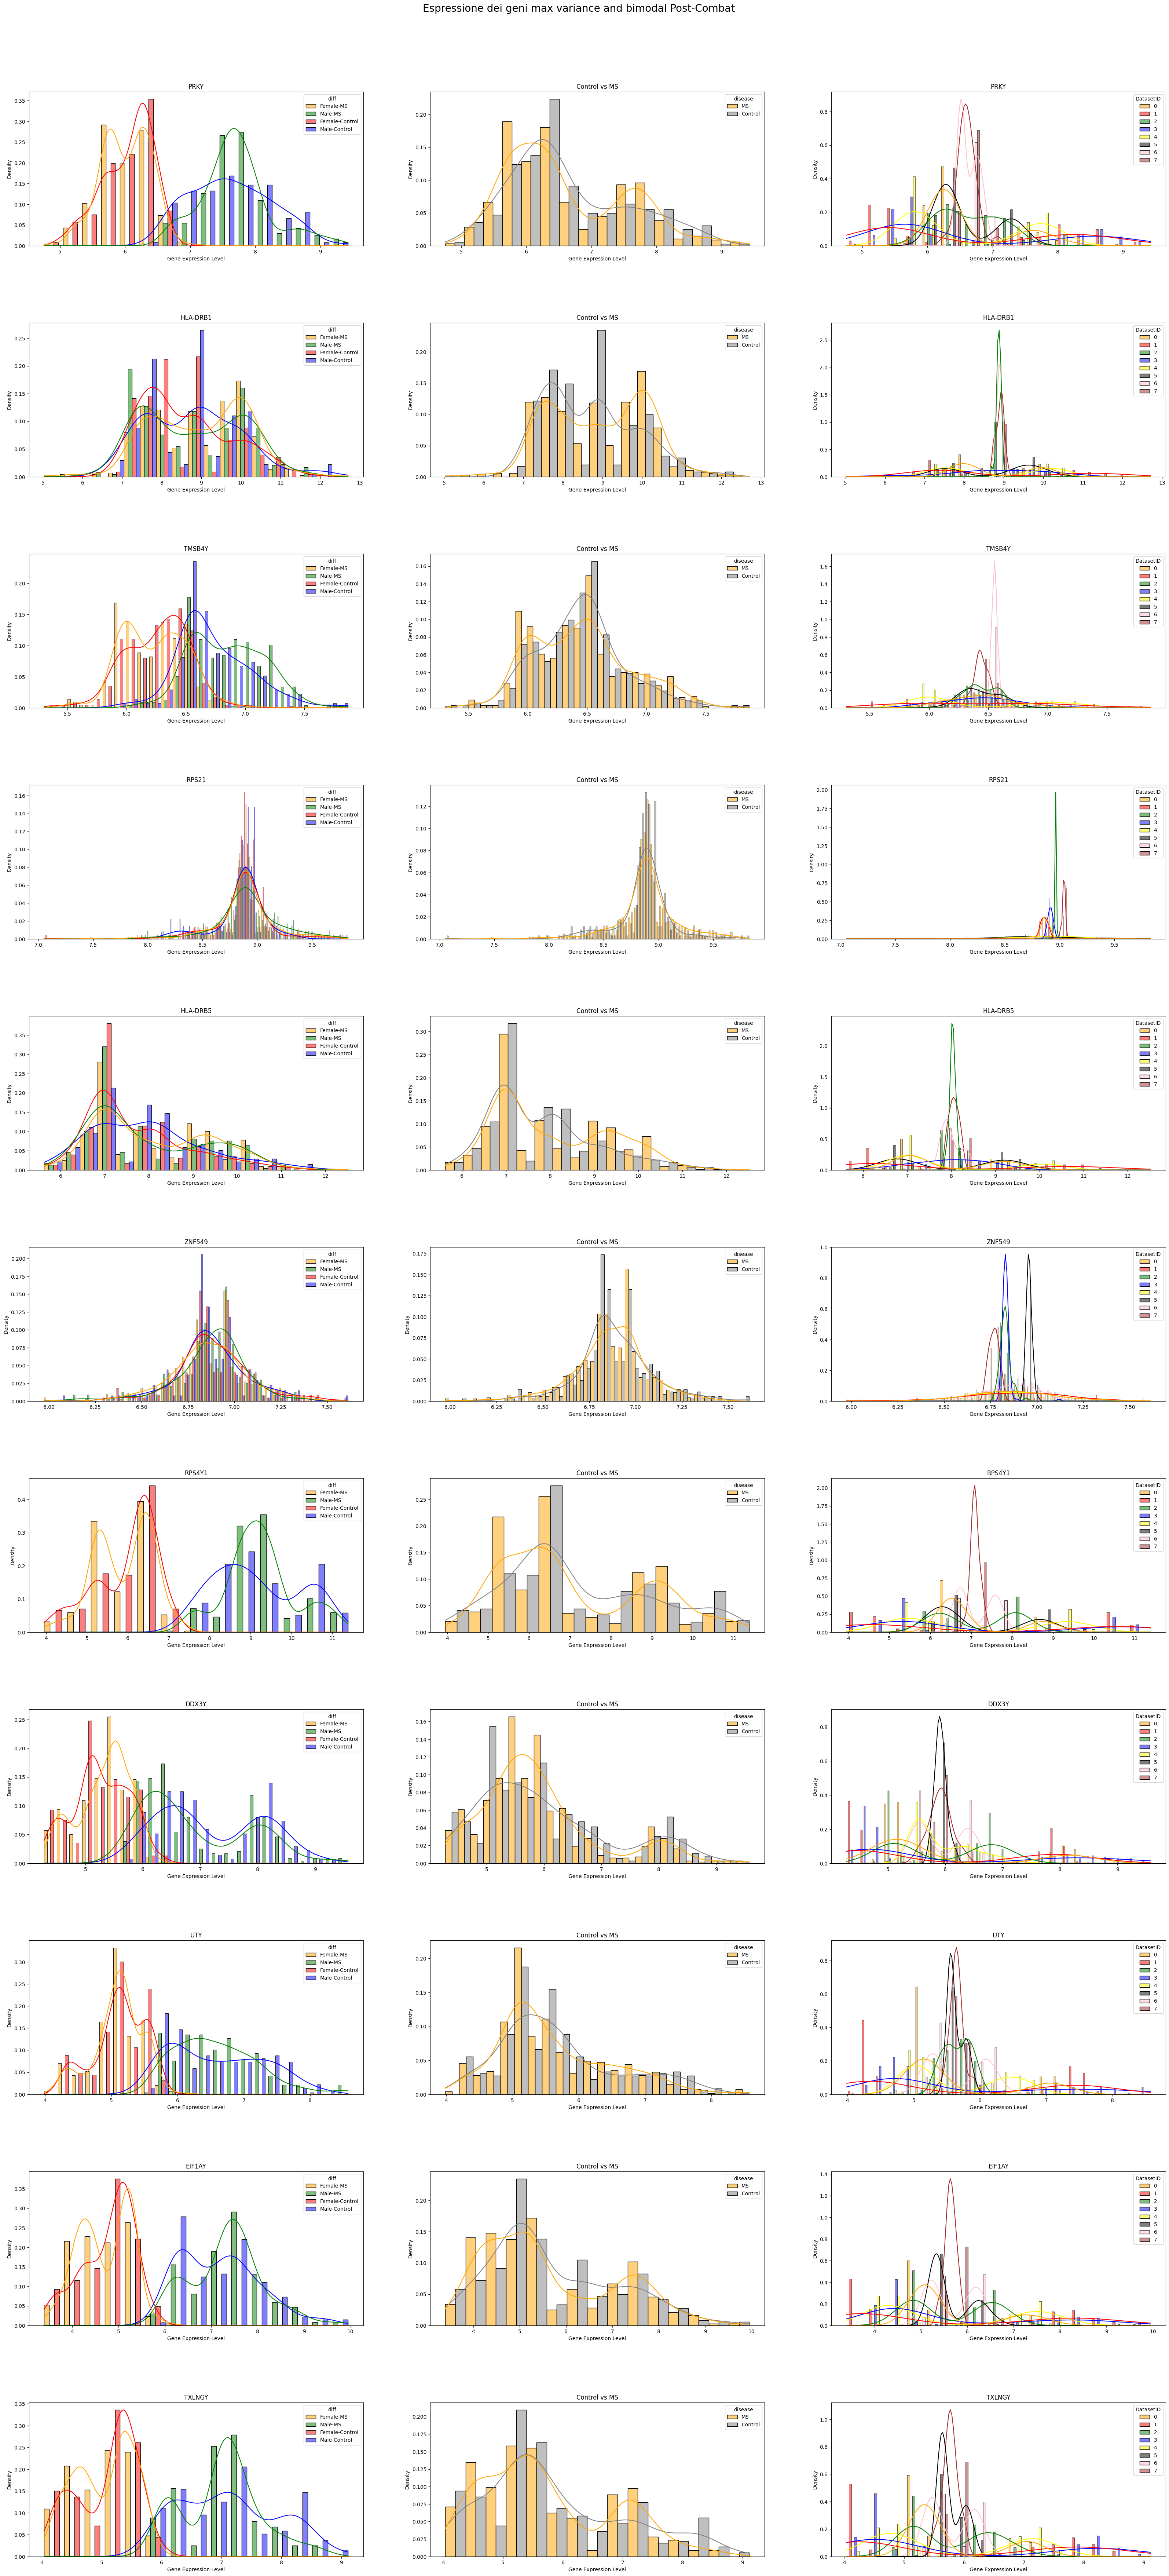

In [33]:
current = dataset.copy()
current['Gender'] = current['Gender'].apply(lambda x: 'Male' if x == 1 else 'Female')
current['disease'] = current['Label'].apply(lambda x: 'MS' if x == 1 else 'Control')
current['diff'] = current['Gender']+"-"+current['disease'].astype(str)
current['DatasetID'] = current['SampleID'].apply(lambda x: x.split('-')[0])

gene_list = list(commonBimodal)

fig, axes = plt.subplots(len(gene_list), 3, figsize=(40, 80))

for i, gene in enumerate(gene_list):
    sns.histplot(data=current, x=gene, hue='diff', stat="probability",
                 kde=True, palette={'Female-MS':'orange', 'Female-Control':'red', 'Male-MS':'green', 'Male-Control':'blue'}, multiple='dodge', common_norm=False, ax=axes[i][0])
    axes[i][0].set_title(gene)
    axes[i][0].set_xlabel("Gene Expression Level")
    axes[i][0].set_ylabel("Density")


    sns.histplot(data=current, x=gene, hue='disease', stat="probability",
                 kde=True, palette={'Control': 'grey', 'MS': 'orange'}, multiple='dodge', common_norm=False, ax=axes[i][1])
    axes[i][1].set_title('Control vs MS')
    axes[i][1].set_xlabel("Gene Expression Level")
    axes[i][1].set_ylabel("Density")

    sns.histplot(data=current, x=gene, hue='DatasetID', stat="probability",
                 kde=True, palette={'0':'orange', '1':'red', '2':'green', '3':'blue', '4':'yellow', '5':'black', '6':'pink', '7':'brown'}, multiple='dodge', common_norm=False, ax=axes[i][2])
    axes[i][2].set_title(gene)
    axes[i][2].set_xlabel("Gene Expression Level")
    axes[i][2].set_ylabel("Density")

    plt.subplots_adjust(hspace=0.5)

plt.suptitle("Espressione dei geni max variance and bimodal Post-Combat", fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

<h1>Analisi espressione differenziale</h1>

In [34]:
current = dataset.copy()

warnings.filterwarnings("ignore")

currentControl = current.loc[current['Label'] == 0, :]
currentMS = current.loc[current['Label'] == 1, :]

currentControl.drop(columns=['SampleID', 'Label', 'Gender'], inplace=True)
currentMS.drop(columns=['SampleID', 'Label', 'Gender'], inplace=True)

p_values = [mannwhitneyu(currentControl[gene], currentMS[gene])[1] for gene in currentControl.columns]
boolean, p_values_corrected = fdrcorrection(p_values, alpha=0.05)
deGenes = [gene for gene, sig in zip(currentControl.columns, boolean) if sig]

print(len(deGenes), deGenes)

1229 ['CLSTN1', 'OSBP', 'EHMT1', 'BPI', 'EMC2', 'HBD', 'AP3B1', 'ATP6V0B', 'OSBPL10', 'C2orf42', 'NECTIN2', 'BLVRA', 'IL15', 'GCLC', 'CD248', 'MRPL22', 'ZNF580', 'YARS2', 'EMC10', 'PTBP1', 'PPP2R5D', 'S100A12', 'RBM26', 'PCID2', 'C14orf93', 'PSMB3', 'NUP98', 'STX10', 'MED17', 'HEATR6', 'TSPAN13', 'DCTN3', 'UPF3B', 'MEF2D', 'ATP5MG', 'POLR2K', 'SWAP70', 'BTRC', 'FASLG', 'PBRM1', 'POFUT2', 'CMKLR1', 'CRTAM', 'CDC5L', 'PLGRKT', 'ARHGEF18', 'UEVLD', 'DGKA', 'RNGTT', 'GORASP1', 'NPC1', 'IP6K2', 'ITGB2', 'HEBP1', 'ZNF254', 'ALDH8A1', 'POLDIP3', 'SASH1', 'WBP4', 'IL16', 'SPARC', 'CTSG', 'PIK3R5', 'USP7', 'NDUFA8', 'NSMCE4A', 'UBE2E1', 'FAAH', 'ADGRE5', 'GTF3C1', 'NR1D2', 'GSDMD', 'CSF1R', 'DENND5A', 'CAPN5', 'UAP1L1', 'MS4A1', 'ZNF224', 'SLBP', 'NQO2', 'USP11', 'EAF2', 'NPFF', 'KCNK12', 'GTF2A2', 'ZNF706', 'H2AC8', 'SUPT16H', 'SPATS2L', 'VCL', 'TBC1D5', 'CXCR4', 'DIDO1', 'RFX1', 'TOMM22', 'USPL1', 'GTF3C2', 'UBE2N', 'RFWD3', 'RAB11FIP2', 'SF3B5', 'NREP', 'NDUFB8', 'OPLAH', 'CRTAP', 'VNN2', 'I

In [39]:
from sklearn.mixture import GaussianMixture
import numpy as np

# X_before: dataset PRIMA della correzione del batch effect
# X_after: dataset DOPO la correzione del batch effect
# Supponiamo che ci siano 3 batch iniziali

X_before = datasetPreCombat.drop(columns=['SampleID', 'Label', 'Gender'])
X_after = dataset.drop(columns=['SampleID', 'Label', 'Gender'])

gmm_before = GaussianMixture(n_components=1, random_state=42)
gmm_before.fit(X_before)
score_before = np.mean(gmm_before.score_samples(X_before))  # Media della likelihood

gmm_after = GaussianMixture(n_components=1, random_state=42)
gmm_after.fit(X_after)
score_after = np.mean(gmm_after.score_samples(X_after))  # Media della likelihood

print(score_before, score_after)

lr_statistic = 2 * (score_after - score_before)

# Numero di gradi di libertà: differenza nel numero di parametri tra i modelli (1 componente ciascuno, quindi 0 gradi di libertà)
# In questo caso, la differenza di gradi di libertà è 0, quindi il test chi-quadrato potrebbe non essere valido.
# Ma possiamo comunque ottenere una statistica LR per riferimento.

print(f"LR statistic: {lr_statistic:.2f}")

# Se avessimo dei gradi di libertà, ad esempio 1, calcoliamo la probabilità (p-value)
# In questo caso la distribuzione chi-quadrato dovrebbe avere 1 grado di libertà
df = 1  # differenza nei parametri tra i modelli (ipotetico caso con 2 modelli distinti)
p_value = stats.chi2.sf(lr_statistic, df)

print(f"P-value: {p_value:.4f}")

33018.701555280415 33614.09841755679
LR statistic: 1190.79
P-value: 0.0000
